In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
!wget -O Titanic.csv "https://raw.githubusercontent.com/pranavn91/blockchain/master/train.csv"

--2020-10-26 12:38:22--  https://raw.githubusercontent.com/pranavn91/blockchain/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘Titanic.csv’

Titanic.csv         100%[===================>]  59.76K  --.-KB/s    in 0.003s  

2020-10-26 12:38:22 (17.4 MB/s) - ‘Titanic.csv’ saved [61194/61194]



In [3]:
titanic=pd.read_csv("Titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
titanic['Age'].fillna(titanic['Age'].median(), inplace = True)

titanic.drop(['Cabin','PassengerId', 'Name','Ticket'], axis = 1, inplace = True)

In [6]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
titanic['Embarked'].fillna('S',inplace=True)

In [8]:
titanic.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [9]:
df_num = titanic.select_dtypes(include=[np.number]).copy()
df_num

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500
...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000
887,1,1,19.0,0,0,30.0000
888,0,3,28.0,1,2,23.4500
889,1,1,26.0,0,0,30.0000


In [10]:
df_cat = titanic.select_dtypes(include='object').copy()
df_cat

,Sex,Embarked
0,male,S
1,female,C
2,female,S
3,female,S
4,male,S
...,...,...
886,male,S
887,female,S
888,female,S
889,male,C


In [11]:
df_cat = pd.get_dummies(df_cat)
df_cat

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1
1,1,0,1,0,0
2,1,0,0,0,1
3,1,0,0,0,1
4,0,1,0,0,1
...,...,...,...,...,...
886,0,1,0,0,1
887,1,0,0,0,1
888,1,0,0,0,1
889,0,1,1,0,0


In [12]:
titanic = pd.concat([df_num,df_cat],axis=1)
titanic

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,28.0,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [13]:
titanic.drop(columns=['Sex_male','Embarked_C'],inplace=True)
titanic

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,1
3,1,1,35.0,1,0,53.1000,1,0,1
4,0,3,35.0,0,0,8.0500,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,1
888,0,3,28.0,1,2,23.4500,1,0,1
889,1,1,26.0,0,0,30.0000,0,0,0


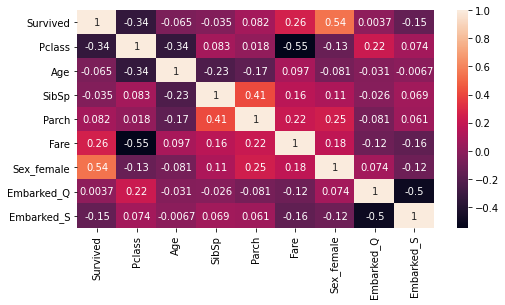

In [14]:
cormat = titanic.corr()
fig, ax = plt.subplots(figsize = [8,4])
sns.heatmap(data = cormat, annot=True)
plt.show()

## NN MODEL

In [15]:
X = titanic.drop(columns=['Survived'])
Y = titanic['Survived']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)
print("x_train_shape"+str(x_train.shape))
print("y_train_shape"+str(y_train.shape))
print("x_test_shape"+str(x_test.shape))
print("y_test_shape"+str(y_test.shape))

x_train_shape(846, 8)
y_train_shape(846,)
x_test_shape(45, 8)
y_test_shape(45,)


In [16]:
nn = models.Sequential()
nn.add(layers.Dense(512, activation="tanh",input_shape=(8, )))
nn.add(layers.Dense(256, activation="sigmoid"))
nn.add(layers.Dense(64, activation="tanh"))
nn.add(layers.Dense(32, activation="relu"))
nn.add(layers.Dense(16, activation="tanh"))
nn.add(layers.Dense(1, activation="sigmoid"))

nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 155,009
Trainable params: 155,009
Non-trainable params: 0
__________________________________________________

In [17]:
nn.compile(optimizer="rmsprop",
           loss='binary_crossentropy',
           metrics = ['accuracy'])

In [18]:
#hyperpara
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [19]:
history = nn.fit(x_train,y_train, epochs=200, validation_split=0.05, verbose=0, callbacks=[es, mc])


Epoch 00001: val_accuracy improved from -inf to 0.62791, saving model to best_model.h5

Epoch 00002: val_accuracy improved from 0.62791 to 0.69767, saving model to best_model.h5

Epoch 00003: val_accuracy did not improve from 0.69767

Epoch 00004: val_accuracy did not improve from 0.69767

Epoch 00005: val_accuracy improved from 0.69767 to 0.74419, saving model to best_model.h5

Epoch 00006: val_accuracy did not improve from 0.74419

Epoch 00007: val_accuracy improved from 0.74419 to 0.81395, saving model to best_model.h5

Epoch 00008: val_accuracy did not improve from 0.81395

Epoch 00009: val_accuracy did not improve from 0.81395

Epoch 00010: val_accuracy did not improve from 0.81395

Epoch 00011: val_accuracy did not improve from 0.81395

Epoch 00012: val_accuracy did not improve from 0.81395

Epoch 00013: val_accuracy did not improve from 0.81395

Epoch 00014: val_accuracy did not improve from 0.81395

Epoch 00015: val_accuracy did not improve from 0.81395

Epoch 00016: val_accur

In [20]:
saved_model = load_model('best_model.h5')

In [21]:
_, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Test: %.3f' % ( test_acc))

Test: 0.800


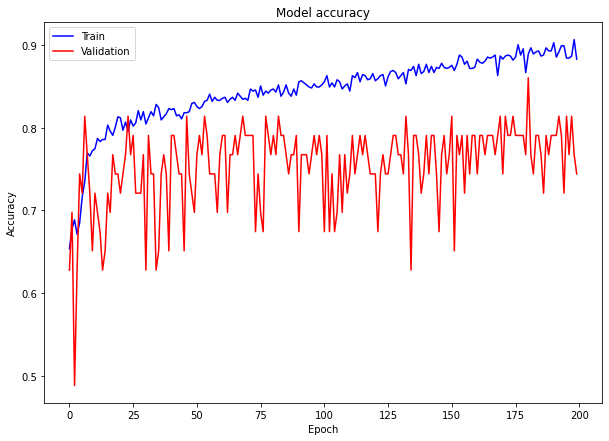

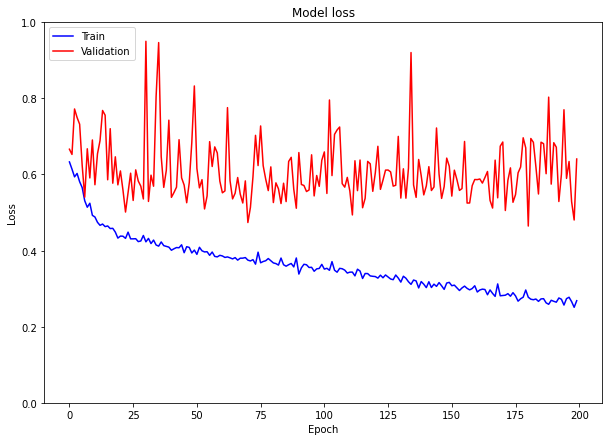

In [22]:
plt.figure(figsize = (10,7))
plt.plot(history.history['accuracy'], color = 'blue')
plt.plot(history.history['val_accuracy'], color = 'red')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize = (10,7))
plt.plot(history.history['loss'], color = 'blue')
plt.plot(history.history['val_loss'], color = 'red')
plt.ylim((0,1))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Parameters
The parameters in this neural network were here were:

Activation layers

First layer of tanh with 512 nodes, having 512*8 weights and 512 biases

Second layer of sigmoid with 256 nodes, having 512*256 weights and 256 biases

Third layer of tanh with 64 nodes, having 256*64 weights and 64 biases

Fourth layer of relu with 32 nodes, having 64*32 weights and 32 biases

Fifth layer of tanh with 16 nodes, having 32*16 weights and 16 biases

Output layer of sigmoid with 1 node, having 16*1 weights and 1 biase.

In [23]:
from sklearn.datasets import fetch_covtype
forest = fetch_covtype()

In [24]:
x_fetch_covtype = forest.data
y_fetch_covtype = forest.target
X = pd.DataFrame(x_fetch_covtype)
Y = pd.DataFrame(y_fetch_covtype)
print(X.shape)
print(Y.shape)

(581012, 54)
(581012, 1)


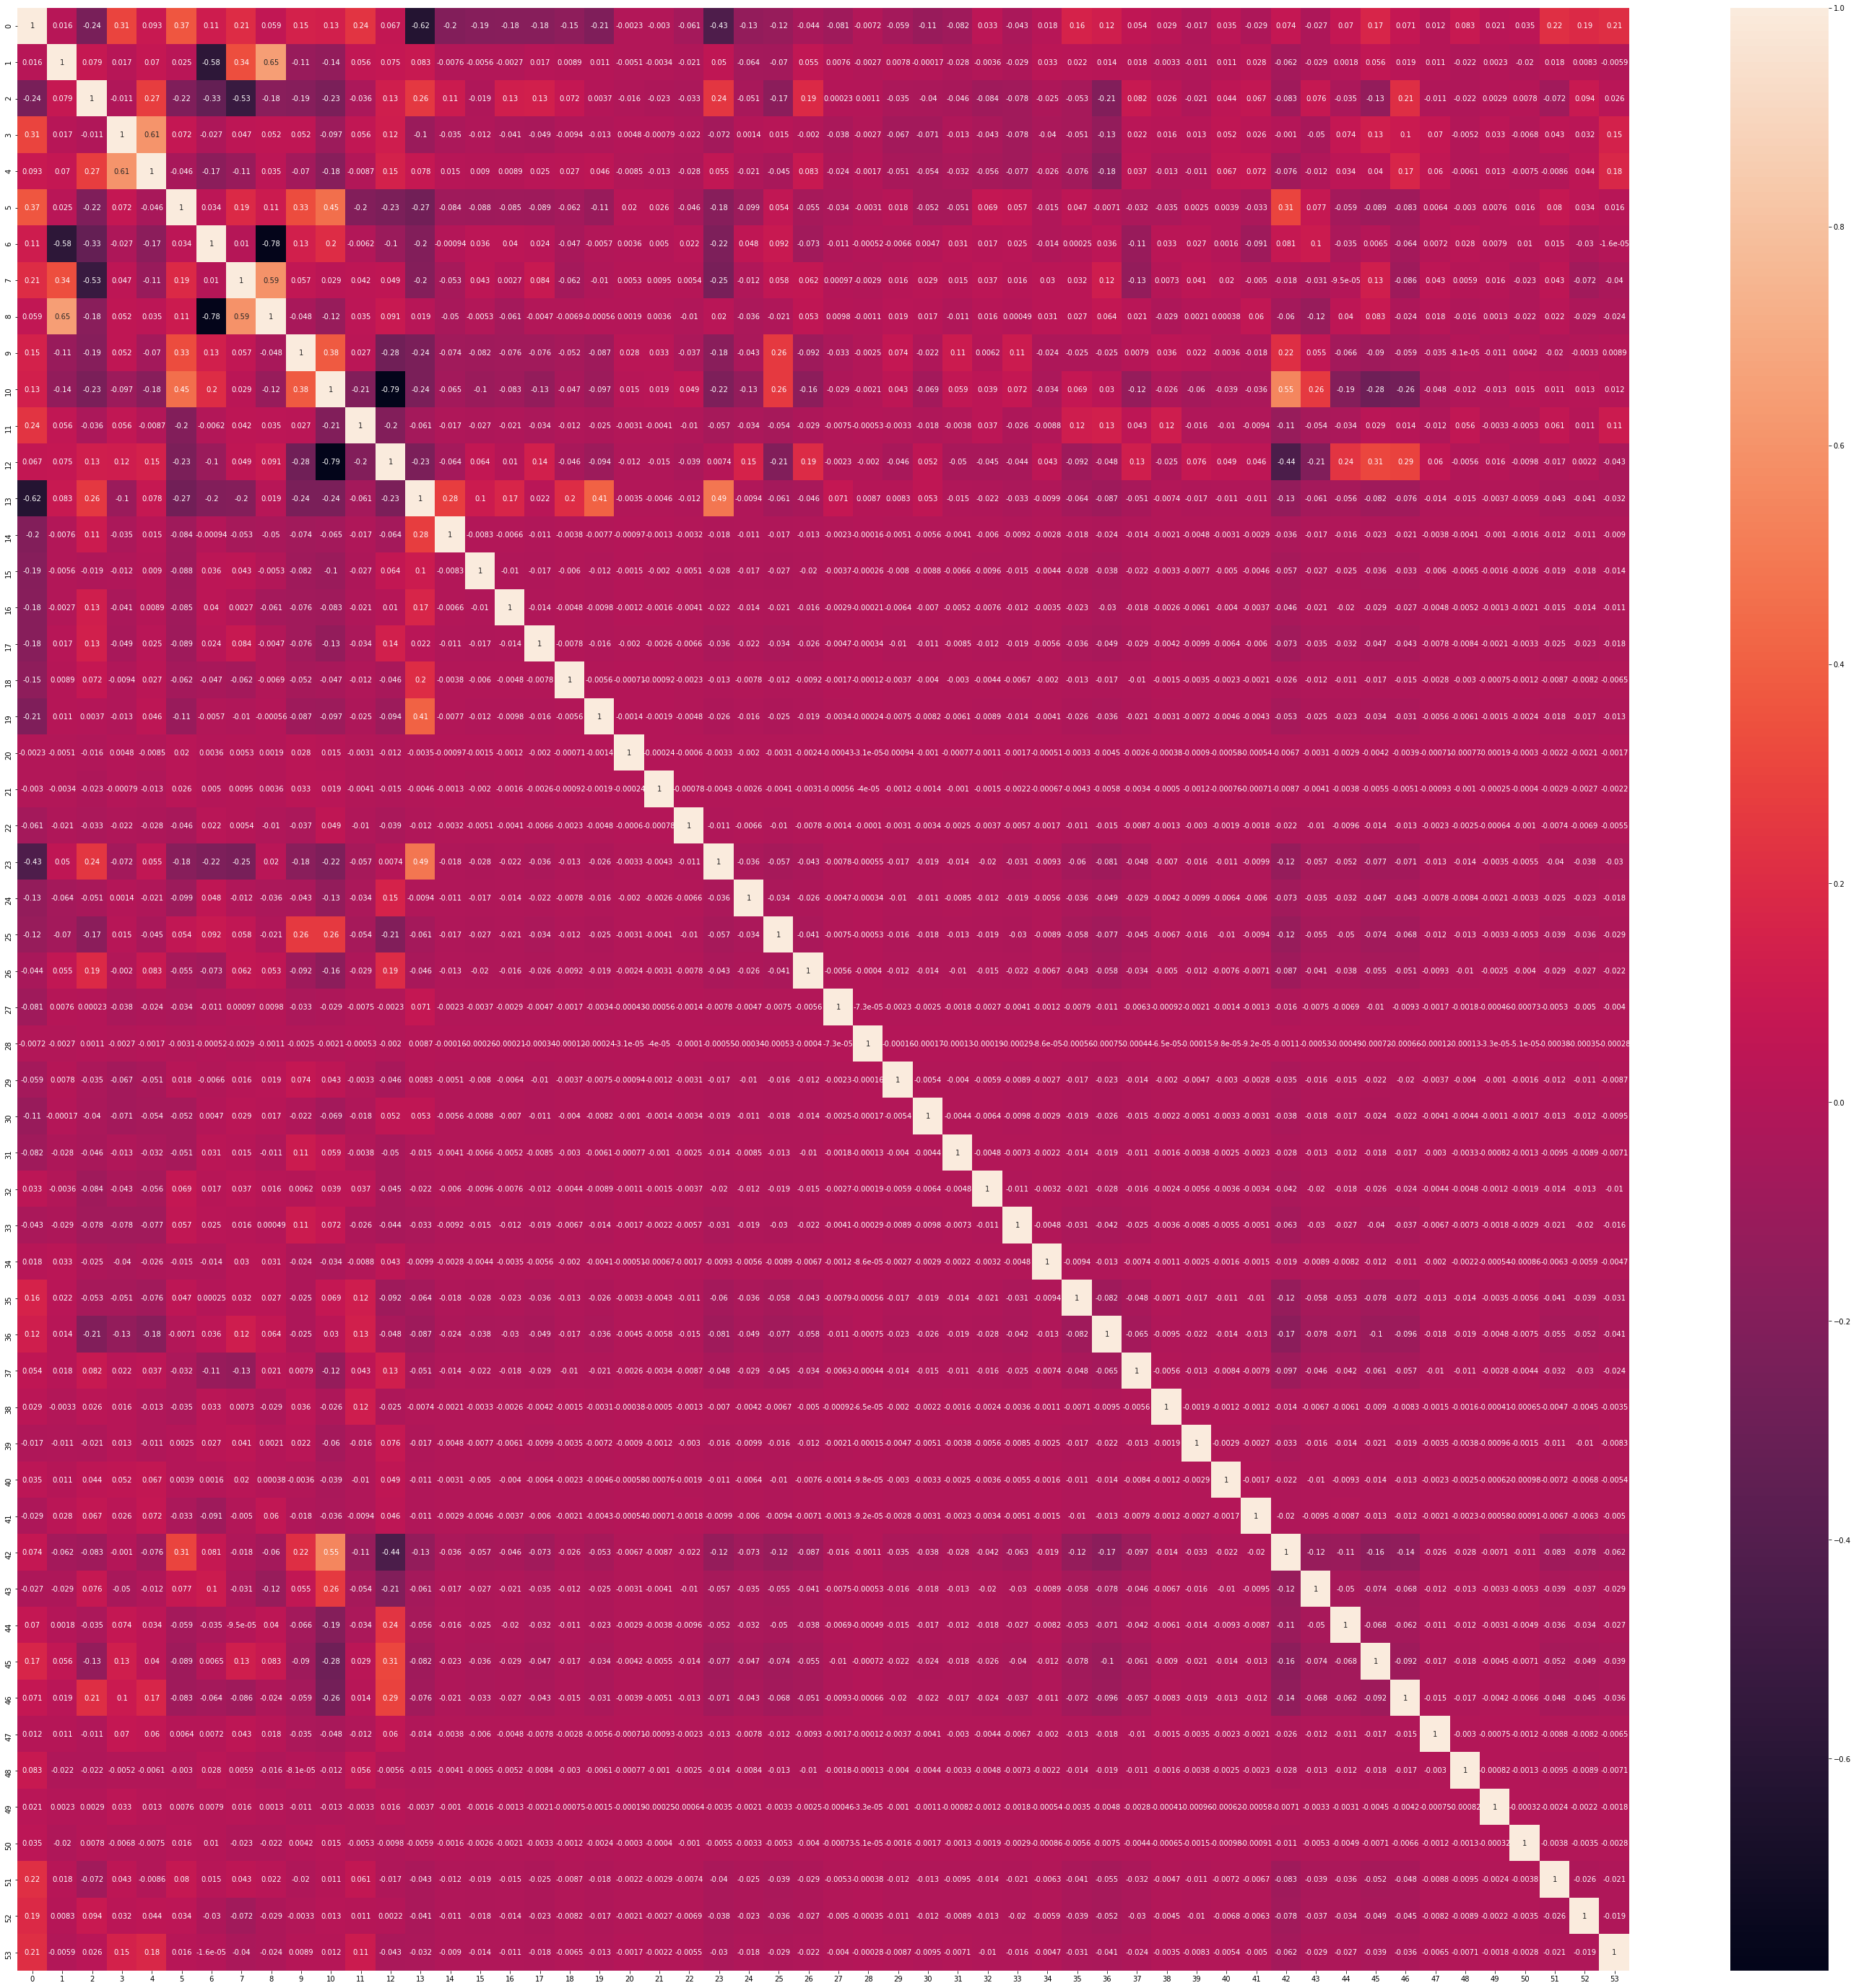

In [25]:
cormat = X.corr()
fig, ax = plt.subplots(figsize = [50,50])
sns.heatmap(data = cormat, annot=True)
plt.show()

In [26]:
Y = to_categorical(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)
print("x_train_shape"+str(x_train.shape))
print("y_train_shape"+str(y_train.shape))
print("x_test_shape"+str(x_test.shape))
print("y_test_shape"+str(y_test.shape))

x_train_shape(551961, 54)
y_train_shape(551961, 8)
x_test_shape(29051, 54)
y_test_shape(29051, 8)


In [27]:
nn = models.Sequential()
nn.add(layers.Dense(512, activation="relu",input_shape=(41, )))
nn.add(layers.Dense(256, activation="relu"))
nn.add(layers.Dense(64, activation="relu"))
nn.add(layers.Dense(32, activation="relu"))
nn.add(layers.Dense(16, activation="relu"))
nn.add(layers.Dense(23, activation="softmax"))

nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               21504     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 23)                391       
Total params: 172,279
Trainable params: 172,279
Non-trainable params: 0
________________________________________________

In [28]:
nn.compile(optimizer="rmsprop",
           loss='categorical_crossentropy',
           metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = nn.fit(x_train,y_train, epochs=200, batch_size = 5000, validation_split=0.05, verbose=0, callbacks=[es, mc])

In [ ]:
_, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Test: %.3f' % ( test_acc))

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(history.history['accuracy'], color = 'blue')
plt.plot(history.history['val_accuracy'], color = 'red')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize = (10,7))
plt.plot(history.history['loss'], color = 'blue')
plt.plot(history.history['val_loss'], color = 'red')
plt.ylim((0,1))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Dataset: Breast Cancer

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [ ]:
X = cancer.data
Y = cancer.target
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)
print(X.shape)
print(Y.shape)

In [ ]:
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
cormat = X.corr()
fig, ax = plt.subplots(figsize = [30,30])
sns.heatmap(data = cormat, annot=True)
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)
print("x_train_shape"+str(x_train.shape))
print("y_train_shape"+str(y_train.shape))
print("x_test_shape"+str(x_test.shape))
print("y_test_shape"+str(y_test.shape))

In [ ]:
nn = models.Sequential()
nn.add(layers.Dense(512, activation="tanh",input_shape=(30, )))
nn.add(layers.Dense(256, activation="sigmoid"))
nn.add(layers.Dense(64, activation="tanh"))
nn.add(layers.Dense(32, activation="relu"))
nn.add(layers.Dense(16, activation="tanh"))
nn.add(layers.Dense(1, activation="sigmoid"))

nn.summary()

In [ ]:

nn.compile(optimizer="rmsprop",
           loss='binary_crossentropy',
           metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [ ]:
history = nn.fit(x_train,y_train, epochs=5000, batch_size = 5000, validation_split=0.05, verbose=0, callbacks=[es, mc])

In [ ]:
saved_model = load_model('best_model.h5')
_, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Test: %.3f' % ( test_acc))

# Plots

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(history.history['accuracy'], color = 'blue')
plt.plot(history.history['val_accuracy'], color = 'red')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize = (10,7))
plt.plot(history.history['loss'], color = 'blue')
plt.plot(history.history['val_loss'], color = 'red')
plt.ylim((0,1))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Dataset: Load Wine

In [ ]:
from sklearn.datasets import load_wine
wine = load_wine()

In [ ]:
X = wine.data
Y = wine.target
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)
print(X.shape)
print(Y.shape)

In [ ]:
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
cormat = X.corr()
fig, ax = plt.subplots(figsize = [13,13])
sns.heatmap(data = cormat, annot=True)
plt.show()

In [ ]:
Y = to_categorical(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)
print("x_train_shape"+str(x_train.shape))
print("y_train_shape"+str(y_train.shape))
print("x_test_shape"+str(x_test.shape))
print("y_test_shape"+str(y_test.shape))

In [ ]:
nn = models.Sequential()
nn.add(layers.Dense(128, activation="relu",input_shape=(13, )))
nn.add(layers.Dense(64, activation="relu"))
nn.add(layers.Dense(32, activation="relu"))
nn.add(layers.Dense(16, activation="relu"))
nn.add(layers.Dense(3, activation="softmax"))

nn.summary()

In [ ]:
nn.compile(optimizer="rmsprop",
           loss='categorical_crossentropy',
           metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = nn.fit(x_train,y_train, epochs=5000, batch_size = 1000, validation_split=0.05, verbose=0, callbacks=[es, mc])

In [ ]:
saved_model = load_model('best_model.h5')
_, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Test: %.3f' % ( test_acc))

In [ ]:

plt.figure(figsize = (10,7))
plt.plot(history.history['accuracy'], color = 'blue')
plt.plot(history.history['val_accuracy'], color = 'red')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize = (10,7))
plt.plot(history.history['loss'], color = 'blue')
plt.plot(history.history['val_loss'], color = 'red')
plt.ylim((0,1))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()